## Import

In [3]:
import pandas as pd
from konlpy.tag import Okt
import numpy as np
from collections import Counter

## Data Load

In [4]:
# 데이터를 읽어봅시다.
train_data = pd.read_table('/content/drive/MyDrive/아이펠/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/아이펠/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
# Okt 초기화
okt = Okt()

# 불용어 리스트
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

def preprocess_text(text):
    """ 텍스트를 토큰화하고 불용어를 제거하는 함수 """
    tokens = okt.morphs(text)  # Mecab 대신 Okt 사용
    tokens = [word for word in tokens if word not in stopwords]
    return tokens

def build_vocab(sentences, num_words=None):
    """ 코퍼스로부터 단어 사전을 생성하는 함수 """
    word_counts = Counter(word for sentence in sentences for word in sentence)
    most_common_words = word_counts.most_common(num_words) if num_words else list(word_counts.items())

    # 인덱스 매핑
    word_to_index = {word: idx + 2 for idx, (word, _) in enumerate(most_common_words)}
    word_to_index["<PAD>"] = 0  # Padding
    word_to_index["<UNK>"] = 1  # Unknown
    return word_to_index

def text_to_sequence(sentences, word_to_index):
    """ 단어 리스트를 정수 인덱스 리스트로 변환하는 함수 """
    return [[word_to_index.get(word, word_to_index["<UNK>"]) for word in sentence] for sentence in sentences]

def load_data(train_data, test_data, num_words=None):
    """ 데이터 로딩 및 전처리 함수 """

    # 예외 처리: 데이터가 비어있는 경우
    if train_data.empty or test_data.empty:
        raise ValueError("입력 데이터셋이 비어 있습니다. 데이터를 확인하세요.")

    # 중복 제거 및 NaN 값 제거
    train_data = train_data.drop_duplicates().dropna()
    test_data = test_data.drop_duplicates().dropna()

    # 텍스트 및 라벨 추출 ('text' -> 'document'로 변경)
    X_train, y_train = train_data['document'].tolist(), train_data['label'].tolist()
    X_test, y_test = test_data['document'].tolist(), test_data['label'].tolist()

    # 텍스트 토큰화 및 전처리
    X_train = [preprocess_text(text) for text in X_train]
    X_test = [preprocess_text(text) for text in X_test]

    # 사전 생성
    word_to_index = build_vocab(X_train + X_test, num_words)

    # 텍스트를 숫자 시퀀스로 변환
    X_train = text_to_sequence(X_train, word_to_index)
    X_test = text_to_sequence(X_test, word_to_index)

    return X_train, y_train, X_test, y_test, word_to_index

In [6]:
# 먼저 데이터 로딩 및 전처리
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

# 그 다음 index_to_word 생성
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 가공

데이터셋 문장 길이 분석을 시작합니다...

훈련 데이터 문장 길이 통계:
평균 길이: 12.55
최대 길이: 95
최소 길이: 0
중앙값: 10.0


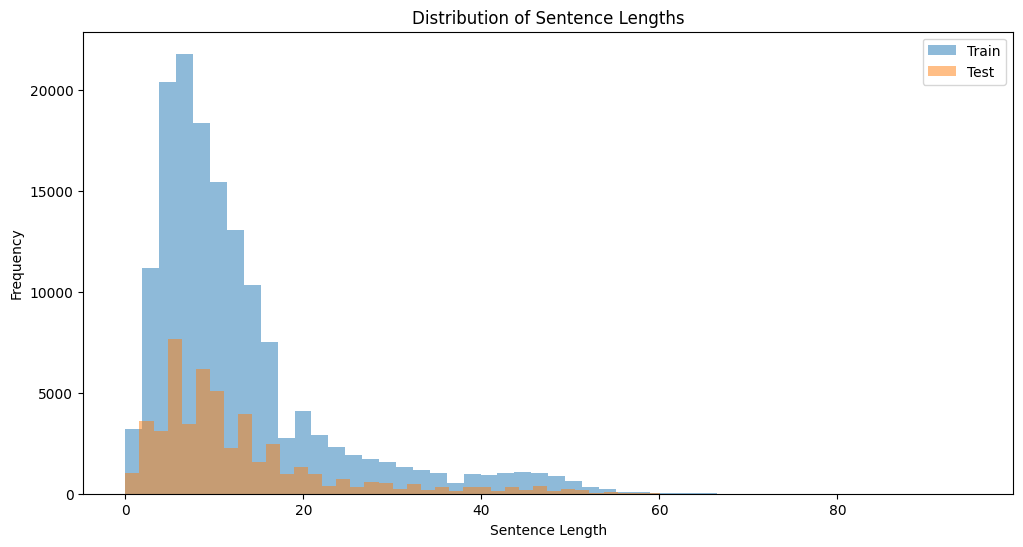


선택된 최대 문장 길이 (95퍼센타일): 37

패딩을 추가합니다...

패딩 결과:
훈련 데이터 shape: (149995, 37)
테스트 데이터 shape: (49997, 37)

패딩된 문장의 예시:
원본 문장 길이: 6
패딩된 문장 길이: 37


In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ===== 1. 문장 길이 분포 분석 =====
print("데이터셋 문장 길이 분석을 시작합니다...")

# 각 문장의 길이를 리스트로 저장
# len()함수로 각 문장의 단어 개수를 계산
train_sentence_lengths = [len(sentence) for sentence in X_train]
test_sentence_lengths = [len(sentence) for sentence in X_test]

# 문장 길이에 대한 기본 통계량 출력
# numpy의 통계 함수들을 사용하여 평균, 최대, 최소, 중앙값 계산
print("\n훈련 데이터 문장 길이 통계:")
print(f"평균 길이: {np.mean(train_sentence_lengths):.2f}")
print(f"최대 길이: {np.max(train_sentence_lengths)}")
print(f"최소 길이: {np.min(train_sentence_lengths)}")
print(f"중앙값: {np.median(train_sentence_lengths)}")

# ===== 2. 문장 길이 분포 시각화 =====
# matplotlib을 사용하여 훈련/테스트 데이터의 문장 길이 분포를 히스토그램으로 표현
plt.figure(figsize=(12, 6))  # 그래프 크기 설정
plt.hist(train_sentence_lengths, bins=50, alpha=0.5, label='Train')  # 훈련 데이터 히스토그램
plt.hist(test_sentence_lengths, bins=50, alpha=0.5, label='Test')    # 테스트 데이터 히스토그램
plt.title('Distribution of Sentence Lengths')  # 그래프 제목
plt.xlabel('Sentence Length')                  # x축 레이블
plt.ylabel('Frequency')                        # y축 레이블
plt.legend()                                   # 범례 표시
plt.show()

# ===== 3. 최대 문장 길이 설정 =====
# 95퍼센타일 지점을 최대 길이로 설정
# 이는 데이터의 95%를 커버하면서도 극단적으로 긴 문장은 제외하는 효과
max_len = int(np.percentile(train_sentence_lengths, 95))
print(f"\n선택된 최대 문장 길이 (95퍼센타일): {max_len}")

# ===== 4. 패딩 처리 =====
print("\n패딩을 추가합니다...")
# keras의 pad_sequences 함수를 사용하여 모든 문장을 동일한 길이로 맞춤
# padding='post': 문장 뒤쪽에 패딩 추가
# truncating='post': 최대 길이 초과시 뒷부분 제거
X_train_pad = pad_sequences(X_train,
                         maxlen=max_len,
                         padding='post',    # 문장 뒤에 패딩 추가
                         truncating='post') # 최대 길이를 초과하는 경우 뒷부분 자르기

X_test_pad = pad_sequences(X_test,
                        maxlen=max_len,
                        padding='post',
                        truncating='post')

# ===== 5. 결과 확인 =====
# 패딩 처리된 데이터의 최종 형태 출력
print("\n패딩 결과:")
print(f"훈련 데이터 shape: {X_train_pad.shape}")  # (샘플 수, 문장 최대 길이)
print(f"테스트 데이터 shape: {X_test_pad.shape}") # (샘플 수, 문장 최대 길이)

# 패딩 전/후 비교를 위한 예시 출력
print("\n패딩된 문장의 예시:")
print("원본 문장 길이:", len(X_train[0]))     # 패딩 전 첫 번째 문장의 길이
print("패딩된 문장 길이:", len(X_train_pad[0])) # 패딩 후 첫 번째 문장의 길이

In [13]:
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
from torch.utils.data import TensorDataset, DataLoader

# BERT 모델에 맞는 토크나이저 초기화
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

def prepare_data(texts, labels, tokenizer, max_len=128):
    """
    텍스트를 BERT 입력 형식으로 변환하는 함수

    Args:
        texts: 텍스트 리스트
        labels: 레이블 리스트
        tokenizer: BERT 토크나이저
        max_len: 최대 시퀀스 길이
    """
    # 문자열 형식 확인 및 변환
    texts = [str(text) for text in texts]

    # 토큰화 및 인코딩
    encodings = tokenizer.encode_plus(
        texts[0],  # 첫 번째 예시로 배치 크기 확인
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # 배치 크기만큼의 텐서 준비
    input_ids = torch.zeros((len(texts), max_len), dtype=torch.long)
    attention_mask = torch.zeros((len(texts), max_len), dtype=torch.long)

    # 각 텍스트를 개별적으로 인코딩
    for idx, text in enumerate(texts):
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids[idx] = encoded['input_ids'][0]
        attention_mask[idx] = encoded['attention_mask'][0]

    # 레이블을 텐서로 변환
    labels = torch.tensor(labels, dtype=torch.long)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }, labels

# 데이터 준비
print("데이터 분할 시작...")
X_train_data, X_val_data, y_train_data, y_val_data = train_test_split(
    train_data['document'].tolist(),
    train_data['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=train_data['label']
)

print(f"훈련 데이터 크기: {len(X_train_data)}")
print(f"검증 데이터 크기: {len(X_val_data)}")

# 데이터 전처리
print("\n토큰화 및 인코딩 중...")
train_encodings, train_labels = prepare_data(X_train_data, y_train_data, tokenizer)
val_encodings, val_labels = prepare_data(X_val_data, y_val_data, tokenizer)

# 데이터셋 생성
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    val_labels
)

# DataLoader 생성
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False
)

print("\n데이터 로더 생성 완료!")
print(f"학습 배치 수: {len(train_dataloader)}")
print(f"검증 배치 수: {len(val_dataloader)}")

데이터 분할 시작...
훈련 데이터 크기: 120000
검증 데이터 크기: 30000

토큰화 및 인코딩 중...

데이터 로더 생성 완료!
학습 배치 수: 3750
검증 배치 수: 938


## 모델 구성 및 validation set 구성 / Loss, Accuracy 그래프 시각화


Training SimpleNN
Epoch 1, Training Loss: 0.5549, Training Accuracy: 0.7213, Validation Loss: 0.4785, Validation Accuracy: 0.7791
Epoch 2, Training Loss: 0.4579, Training Accuracy: 0.7917, Validation Loss: 0.4577, Validation Accuracy: 0.7914
Epoch 3, Training Loss: 0.4434, Training Accuracy: 0.7995, Validation Loss: 0.4526, Validation Accuracy: 0.7955
Epoch 4, Training Loss: 0.4372, Training Accuracy: 0.8023, Validation Loss: 0.4552, Validation Accuracy: 0.7917
Epoch 5, Training Loss: 0.4334, Training Accuracy: 0.8058, Validation Loss: 0.4523, Validation Accuracy: 0.7968


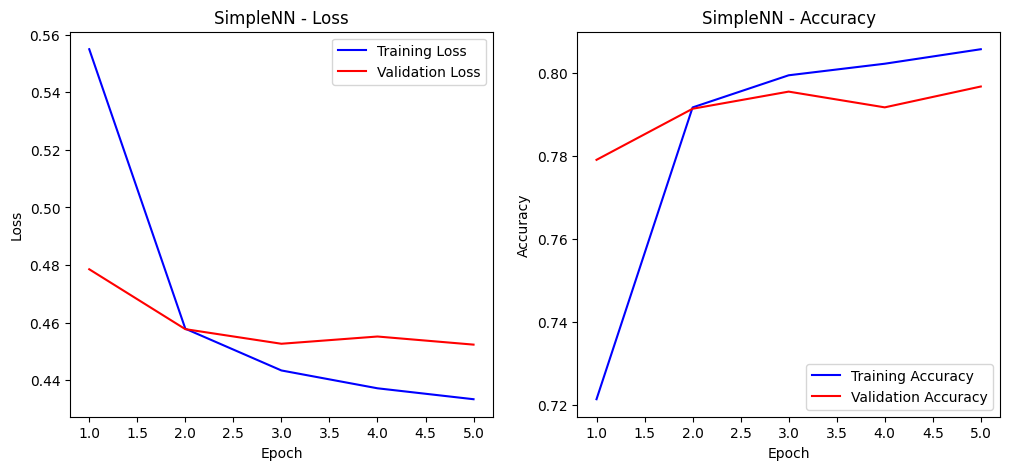


Training CNNTextClassifier
Epoch 1, Training Loss: 0.4342, Training Accuracy: 0.7911, Validation Loss: 0.3900, Validation Accuracy: 0.8176
Epoch 2, Training Loss: 0.3550, Training Accuracy: 0.8399, Validation Loss: 0.3816, Validation Accuracy: 0.8250
Epoch 3, Training Loss: 0.3150, Training Accuracy: 0.8613, Validation Loss: 0.3711, Validation Accuracy: 0.8316
Epoch 4, Training Loss: 0.2786, Training Accuracy: 0.8809, Validation Loss: 0.3751, Validation Accuracy: 0.8332
Epoch 5, Training Loss: 0.2410, Training Accuracy: 0.8995, Validation Loss: 0.4062, Validation Accuracy: 0.8326


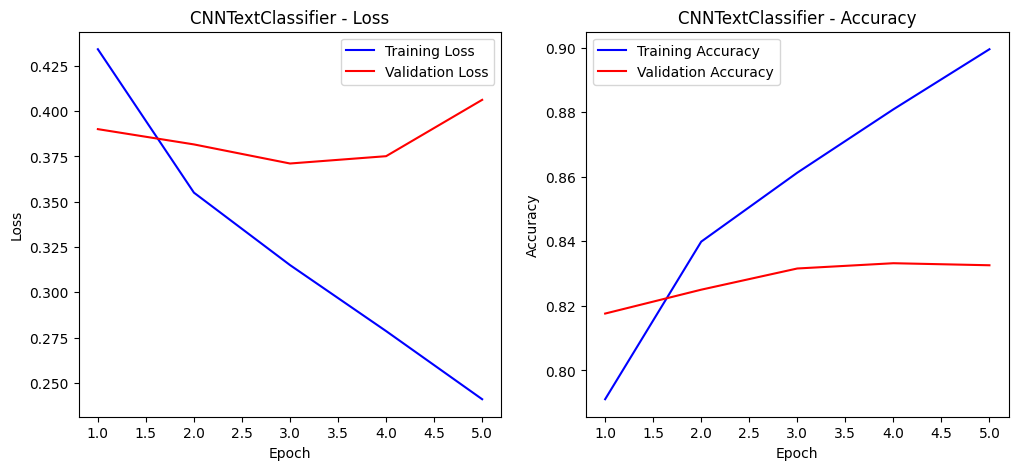


Training LSTMTextClassifier
Epoch 1, Training Loss: 0.6935, Training Accuracy: 0.4999, Validation Loss: 0.6932, Validation Accuracy: 0.4988
Epoch 2, Training Loss: 0.6932, Training Accuracy: 0.4990, Validation Loss: 0.6933, Validation Accuracy: 0.5012
Epoch 3, Training Loss: 0.6932, Training Accuracy: 0.4993, Validation Loss: 0.6933, Validation Accuracy: 0.4988
Epoch 4, Training Loss: 0.6932, Training Accuracy: 0.5004, Validation Loss: 0.6933, Validation Accuracy: 0.5012
Epoch 5, Training Loss: 0.5644, Training Accuracy: 0.6623, Validation Loss: 0.4192, Validation Accuracy: 0.8027


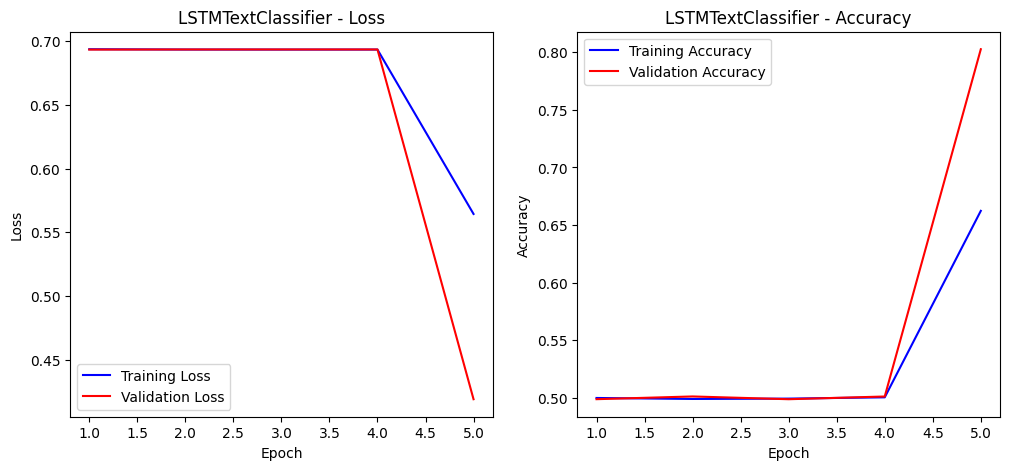

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ===== 1. 간단한 텍스트 분류 모델 정의 =====

class SimpleNN(nn.Module):
    """
    간단한 신경망 기반의 텍스트 분류 모델
    - 임베딩 + 평균 풀링 + Fully Connected Layer
    """
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)  # 임베딩 적용
        pooled = torch.mean(embedded, dim=1)  # 문장 단위 평균 풀링
        return self.fc(pooled)


class CNNTextClassifier(nn.Module):
    """
    CNN 기반의 텍스트 분류 모델
    - CNN을 사용하여 문맥적 특징을 추출하고 분류 수행
    """
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        embedded = self.embedding(x).permute(0, 2, 1)  # Conv1d 입력 형태로 변환
        x = F.relu(self.conv1(embedded))
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=x.shape[2]).squeeze(2)  # Global Max Pooling
        return self.fc(x)


class LSTMTextClassifier(nn.Module):
    """
    LSTM 기반의 텍스트 분류 모델
    - 시퀀스 데이터를 학습하여 문맥 정보를 반영한 분류 수행
    """
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(LSTMTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        return self.fc(hidden[-1])  # 최종 LSTM 은닉 상태를 출력층으로 연결

# ===== 2. 모델 설정 및 학습 준비 =====
vocab_size = len(word_to_index)
embed_dim = 128
num_classes = 2
hidden_dim = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {
    "SimpleNN": SimpleNN(vocab_size, embed_dim, num_classes).to(device),
    "CNNTextClassifier": CNNTextClassifier(vocab_size, embed_dim, num_classes).to(device),
    "LSTMTextClassifier": LSTMTextClassifier(vocab_size, embed_dim, hidden_dim, num_classes).to(device)
}

# ===== 3. 학습 함수 정의 =====
def train_model(model, train_dataloader, val_dataloader, epochs=5):
    """
    모델 학습을 수행하는 함수
    - Adam 옵티마이저 사용
    - CrossEntropyLoss 사용
    - 매 에포크마다 검증 데이터 평가 수행
    """
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_train, total_train = 0, 0

        for batch in train_dataloader:
            batch = [t.to(device) for t in batch]

            # 🛠 수정: 올바른 unpacking 적용
            input_ids, attention_mask, labels = batch  # ❗여기서 3개 값을 받아야 함

            optimizer.zero_grad()
            outputs = model(input_ids)  # `attention_mask`가 필요하면 모델 forward에서 반영 필요
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_loss = total_loss / len(train_dataloader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_loss)
        train_accuracies.append(train_accuracy)

        # === 검증 평가 ===
        model.eval()
        correct_val, total_val, val_loss = 0, 0, 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = [t.to(device) for t in batch]

                # 🛠 수정: 검증 데이터도 동일하게 unpack
                input_ids, attention_mask, labels = batch  # ❗여기서 3개 값을 받아야 함

                outputs = model(input_ids)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = torch.argmax(outputs, dim=1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_losses.append(val_loss / len(val_dataloader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

# ===== 4. 학습 결과 시각화 함수 =====
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model_name):
    """
    Loss 및 Accuracy를 시각화하는 함수
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{model_name} - Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f'{model_name} - Accuracy')

    plt.show()

# ===== 5. 모델 학습 실행 =====
for model_name, model in models.items():
    print(f"\nTraining {model_name}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, val_dataloader)
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model_name)

## 학습된 Embedding 레이어 분석

In [22]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 설정 변경 (나눔고딕이 설치되어 있다면 적용)
plt.rc('font', family='Malgun Gothic')  # Windows: 맑은고딕
# plt.rc('font', family='AppleGothic')  # macOS: 애플고딕
# plt.rc('font', family='NanumGothic')  # Linux: 나눔고딕 (설치 필요)

# 마이너 경고 제거 (폰트 관련)
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")


Visualizing Embeddings for SimpleNN
Vocabulary Size: 122878, Embedding Dimension: 128


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45908 (\N{HANGUL SYLLABLE DEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48729 (\N{HANGUL SYLLABLE BING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

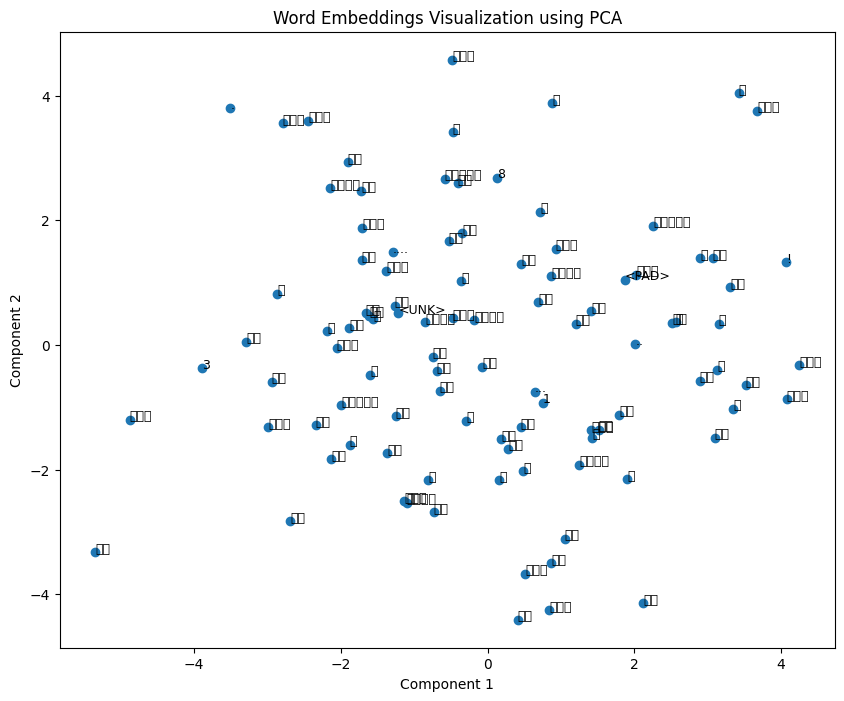


Visualizing Embeddings for CNNTextClassifier
Vocabulary Size: 122878, Embedding Dimension: 128


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45908 (\N{HANGUL SYLLABLE DEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48729 (\N{HANGUL SYLLABLE BING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

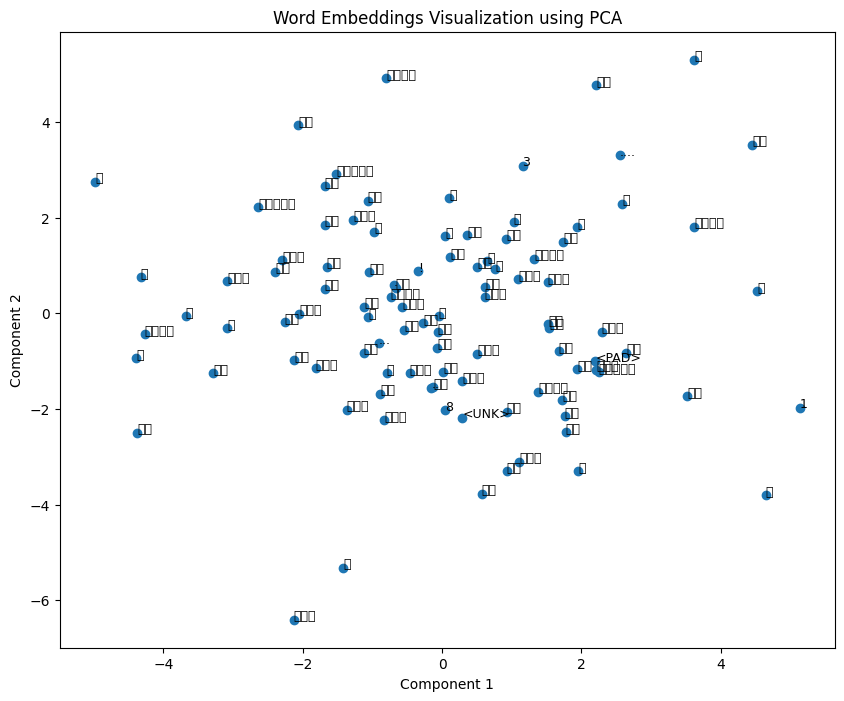


Visualizing Embeddings for LSTMTextClassifier
Vocabulary Size: 122878, Embedding Dimension: 128


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45908 (\N{HANGUL SYLLABLE DEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48729 (\N{HANGUL SYLLABLE BING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

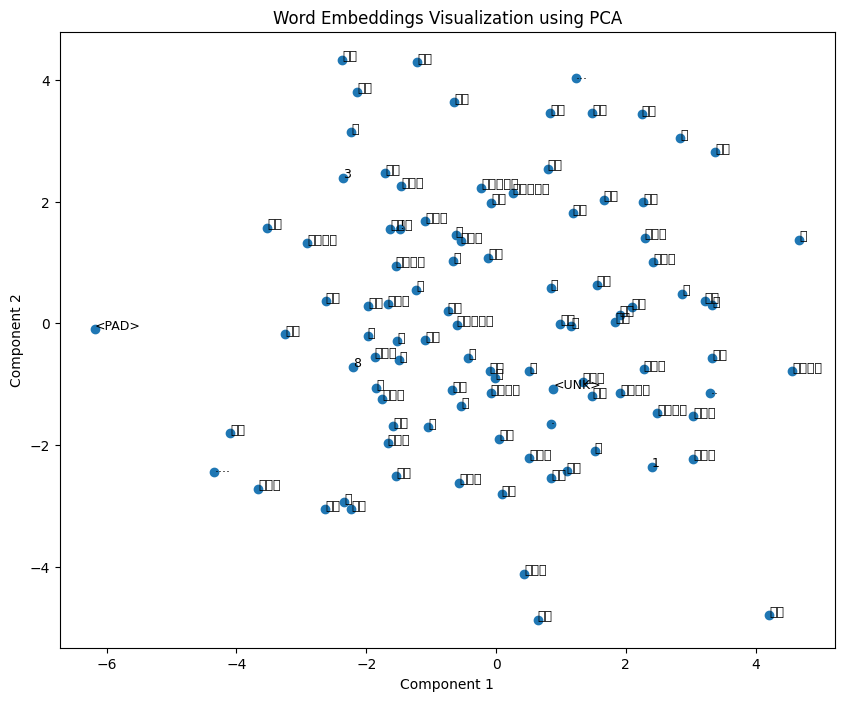

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

def visualize_embedding(model, word_to_index, method='pca', num_words=100):
    """
    학습된 임베딩 벡터를 시각화하는 함수
    - method: 'pca' 또는 'tsne' 선택 가능
    - num_words: 시각화할 단어 개수 (임베딩 벡터가 많으면 일부만 선택)
    """

    # 모델의 임베딩 레이어에서 가중치 (word embeddings) 추출
    embedding_weights = model.embedding.weight.cpu().detach().numpy()
    vocab_size, embed_dim = embedding_weights.shape  # 임베딩 벡터 크기 확인

    print(f"Vocabulary Size: {vocab_size}, Embedding Dimension: {embed_dim}")

    # 시각화할 단어 개수를 vocab_size보다 크지 않도록 제한
    num_words = min(num_words, vocab_size)
    selected_embeddings = embedding_weights[:num_words]  # 처음 num_words 개수만 선택

    # 차원 축소 알고리즘 선택 (PCA 또는 t-SNE)
    if method == 'pca':
        reducer = PCA(n_components=2)  # PCA를 사용하여 2차원 축소
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, n_iter=300)  # t-SNE를 사용하여 2차원 축소
    else:
        raise ValueError("method should be either 'pca' or 'tsne'")  # 잘못된 입력 처리

    reduced_embeddings = reducer.fit_transform(selected_embeddings)  # 임베딩 벡터를 2차원으로 변환

    # 단어 리스트 추출 (word_to_index 사전을 ID 순서로 정렬하여 가져오기)
    words = [word for word, idx in sorted(word_to_index.items(), key=lambda x: x[1])][:num_words]

    # 시각화 수행
    plt.figure(figsize=(10, 8))  # 그래프 크기 설정
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], marker="o")  # 단어들을 점으로 표현

    # 각 단어를 그래프에 표시 (위치: 해당 단어의 좌표)
    for i, word in enumerate(words):
        plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=9)

    plt.title(f"Word Embeddings Visualization using {method.upper()}")  # 그래프 제목 설정
    plt.xlabel("Component 1")  # X축 라벨
    plt.ylabel("Component 2")  # Y축 라벨
    plt.show()  # 그래프 출력

# ===== 모델별 임베딩 분석 실행 =====
for model_name, model in models.items():
    print(f"\nVisualizing Embeddings for {model_name}")
    visualize_embedding(model, word_to_index, method='pca', num_words=100)  # PCA를 이용한 시각화

✅ Word2Vec 모델 로드 완료!

Training SimpleNN
Epoch 1, Training Loss: 0.4315, Training Accuracy: 0.8069, Validation Loss: 0.4517, Validation Accuracy: 0.7974
Epoch 2, Training Loss: 0.4294, Training Accuracy: 0.8081, Validation Loss: 0.4532, Validation Accuracy: 0.7962
Epoch 3, Training Loss: 0.4282, Training Accuracy: 0.8093, Validation Loss: 0.4568, Validation Accuracy: 0.7921
Epoch 4, Training Loss: 0.4278, Training Accuracy: 0.8086, Validation Loss: 0.4531, Validation Accuracy: 0.7969


Epoch 5, Training Loss: 0.4259, Training Accuracy: 0.8098, Validation Loss: 0.4543, Validation Accuracy: 0.7963


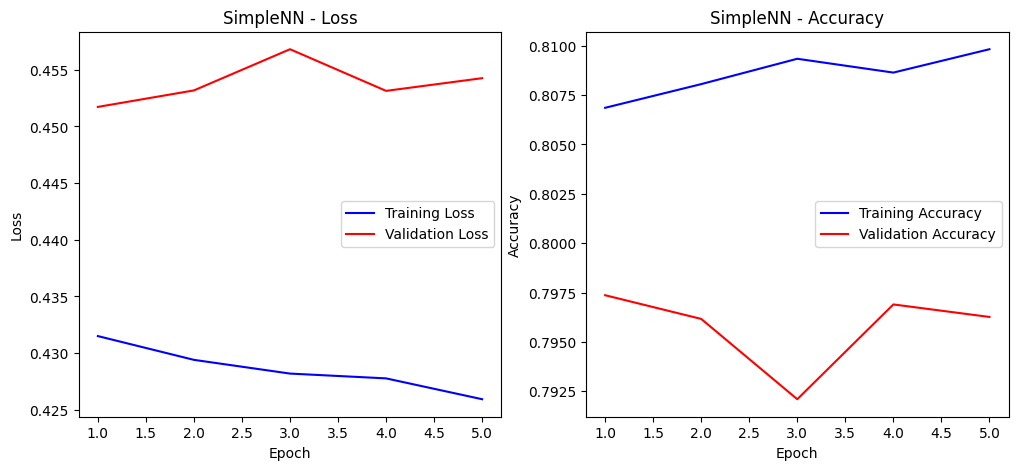


Training CNNTextClassifier
Epoch 1, Training Loss: 0.2058, Training Accuracy: 0.9152, Validation Loss: 0.4352, Validation Accuracy: 0.8284
Epoch 2, Training Loss: 0.1728, Training Accuracy: 0.9299, Validation Loss: 0.5048, Validation Accuracy: 0.8221
Epoch 3, Training Loss: 0.1461, Training Accuracy: 0.9416, Validation Loss: 0.5413, Validation Accuracy: 0.8263
Epoch 4, Training Loss: 0.1260, Training Accuracy: 0.9497, Validation Loss: 0.5898, Validation Accuracy: 0.8192


Epoch 5, Training Loss: 0.1101, Training Accuracy: 0.9568, Validation Loss: 0.6573, Validation Accuracy: 0.8239


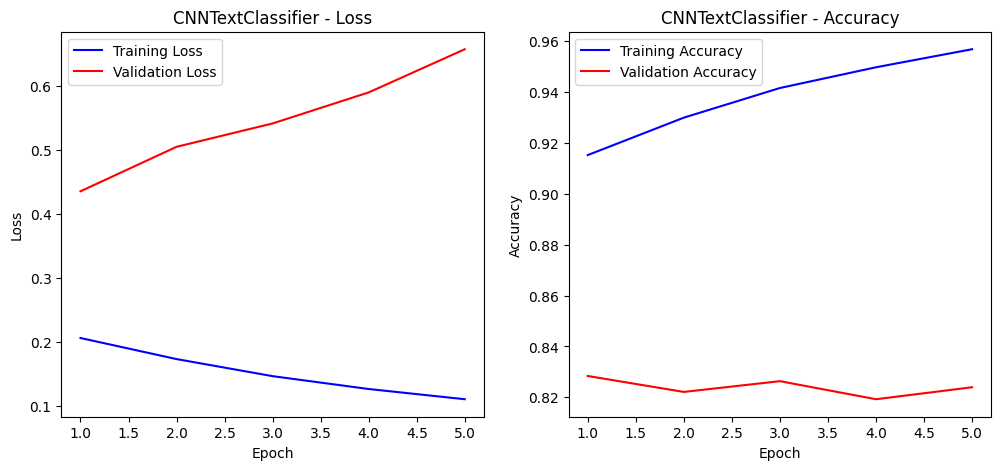


Training LSTMTextClassifier
Epoch 1, Training Loss: 0.3751, Training Accuracy: 0.8307, Validation Loss: 0.3836, Validation Accuracy: 0.8243
Epoch 2, Training Loss: 0.3213, Training Accuracy: 0.8595, Validation Loss: 0.3774, Validation Accuracy: 0.8299
Epoch 3, Training Loss: 0.2738, Training Accuracy: 0.8836, Validation Loss: 0.3964, Validation Accuracy: 0.8288
Epoch 4, Training Loss: 0.2311, Training Accuracy: 0.9051, Validation Loss: 0.4084, Validation Accuracy: 0.8304


Epoch 5, Training Loss: 0.1934, Training Accuracy: 0.9236, Validation Loss: 0.4449, Validation Accuracy: 0.8283


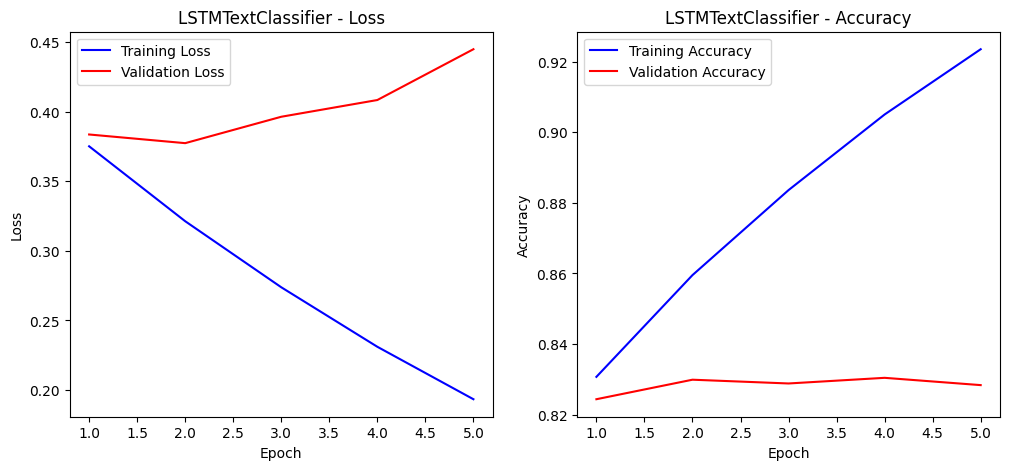


Training Word2VecTextClassifier
Epoch 1, Training Loss: 0.6876, Training Accuracy: 0.5417, Validation Loss: 0.6914, Validation Accuracy: 0.5299
Epoch 2, Training Loss: 0.6778, Training Accuracy: 0.5650, Validation Loss: 0.6794, Validation Accuracy: 0.5434
Epoch 3, Training Loss: 0.6740, Training Accuracy: 0.5728, Validation Loss: 0.6705, Validation Accuracy: 0.5722
Epoch 4, Training Loss: 0.6716, Training Accuracy: 0.5786, Validation Loss: 0.6798, Validation Accuracy: 0.5588


Epoch 5, Training Loss: 0.6697, Training Accuracy: 0.5815, Validation Loss: 0.6794, Validation Accuracy: 0.5598


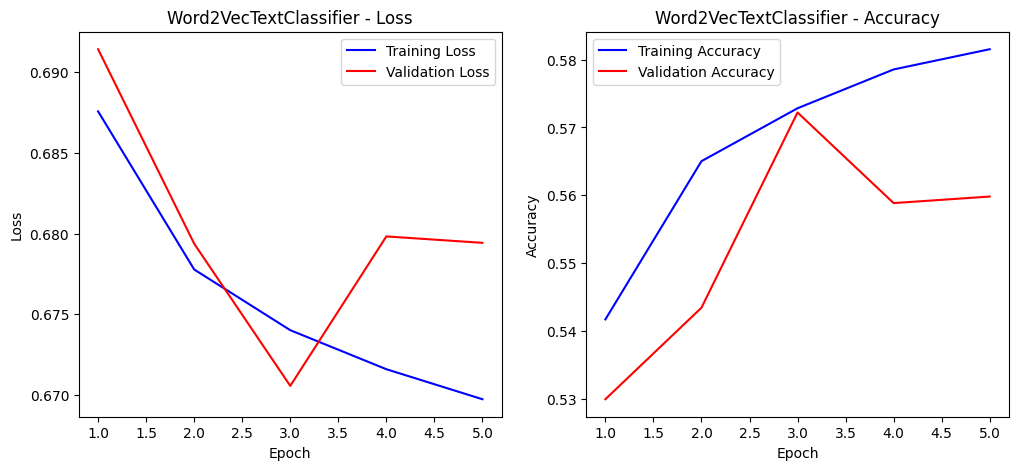

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import gensim
import numpy as np

# ===== 1. 한국어 Word2Vec 모델 불러오기 =====
word2vec_path = "/content/drive/MyDrive/아이펠/sentiment_classification/word2vec_ko.model"
vectors_path = "/content/drive/MyDrive/아이펠/sentiment_classification/word2vec_ko.model.wv.vectors.npy"
syn1neg_path = "/content/drive/MyDrive/아이펠/sentiment_classification/word2vec_ko.model.trainables.syn1neg.npy"


# Word2Vec 모델 불러오기
word2vec = gensim.models.Word2Vec.load(word2vec_path)
print("✅ Word2Vec 모델 로드 완료!")

# Word2Vec에서 단어 사전을 가져오기
word_to_index = {word: idx for idx, word in enumerate(word2vec.wv.index_to_key)}
vocab_size = len(word_to_index)
embed_dim = word2vec.vector_size  # Word2Vec에서 사용된 임베딩 차원

# ===== 3. Word2Vec 임베딩 가중치를 PyTorch로 변환 =====
embedding_matrix = np.zeros((vocab_size, embed_dim))
for word, idx in word_to_index.items():
    embedding_matrix[idx] = word2vec.wv[word]  # Word2Vec 벡터를 삽입

# PyTorch 임베딩 텐서로 변환
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float)

# ===== 4. Word2Vec을 활용한 새로운 텍스트 분류 모델 =====
class Word2VecTextClassifier(nn.Module):
    """
    Word2Vec 임베딩을 적용한 신경망 기반 텍스트 분류 모델
    - 사전 학습된 Word2Vec 가중치를 활용하여 임베딩 레이어 초기화
    - 학습 가능한 임베딩 사용 가능 (freeze=False 시 fine-tuning 가능)
    """
    def __init__(self, vocab_size, embed_dim, num_classes, freeze=True):
        super(Word2VecTextClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, freeze=freeze)  # Word2Vec 적용
        self.fc = nn.Linear(embed_dim, num_classes)  # Fully Connected Layer

    def forward(self, x):
        embedded = self.embedding(x)  # Pretrained Embedding 적용
        pooled = torch.mean(embedded, dim=1)  # 문장 단위 평균 풀링
        return self.fc(pooled)

# 모델 생성
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
word2vec_model = Word2VecTextClassifier(vocab_size, embed_dim, num_classes).to(device)

# ===== 5. 기존 모델과 Word2Vec 모델 학습 비교 =====
models["Word2VecTextClassifier"] = word2vec_model  # 기존 모델 리스트에 추가

for model_name, model in models.items():
    print(f"\nTraining {model_name}")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, val_dataloader)
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, model_name)

---

## 회고
- 모델을 학습시키는데 시간 소모를 많이 해서 학습된 Embedding 레이어 분석, 한국어 Word2Vec 임베딩 활용하여 성능 개선은 코드만 어느정도 구성을 해놓았다.

- 추후에 부족한 부분을 보충하고자 한다.

- 자연어 데이터는 처음 다뤄보아서 전반적으로 어려움이 있었다.